# Pipeline de Dados no Telegram

## 1. Contexto
Este projeto visa à automação do processo de coleta, análise e apresentação de mensagens provenientes de um grupo específico no Telegram, com o objetivo final de transformá-las em dados estruturados e integrá-las em um ambiente SQL. A complexidade dessa iniciativa é decorrente da integração de serviços avançados fornecidos pela AWS (Amazon Web Services), juntamente com a implementação de um bot no Telegram e a utilização da linguagem de programação Python.

A automação proposta, embora concebida para ser de aparente simplicidade, encerra um caráter multifacetado e intricado. A adoção de serviços específicos da AWS visa assegurar uma infraestrutura robusta e escalável para o processamento eficiente das mensagens. A integração de um bot no Telegram servirá como uma interface estratégica para a interação e controle do processo automatizado, proporcionando uma comunicação eficaz.

A escolha da linguagem Python como principal meio de implementação fundamenta-se em sua flexibilidade, extensibilidade e na riqueza de suas bibliotecas, o que facilita a integração e execução eficiente das tarefas propostas. A sinergia entre os componentes tecnológicos, aliada à expertise na configuração e administração de recursos AWS, garantirá uma solução eficaz e de alto desempenho.

## 2. Arquitetura
A seguir, exponho a arquitetura integral do projeto, bem como sua implementação detalhada e uma visão geral visual de seu funcionamento.

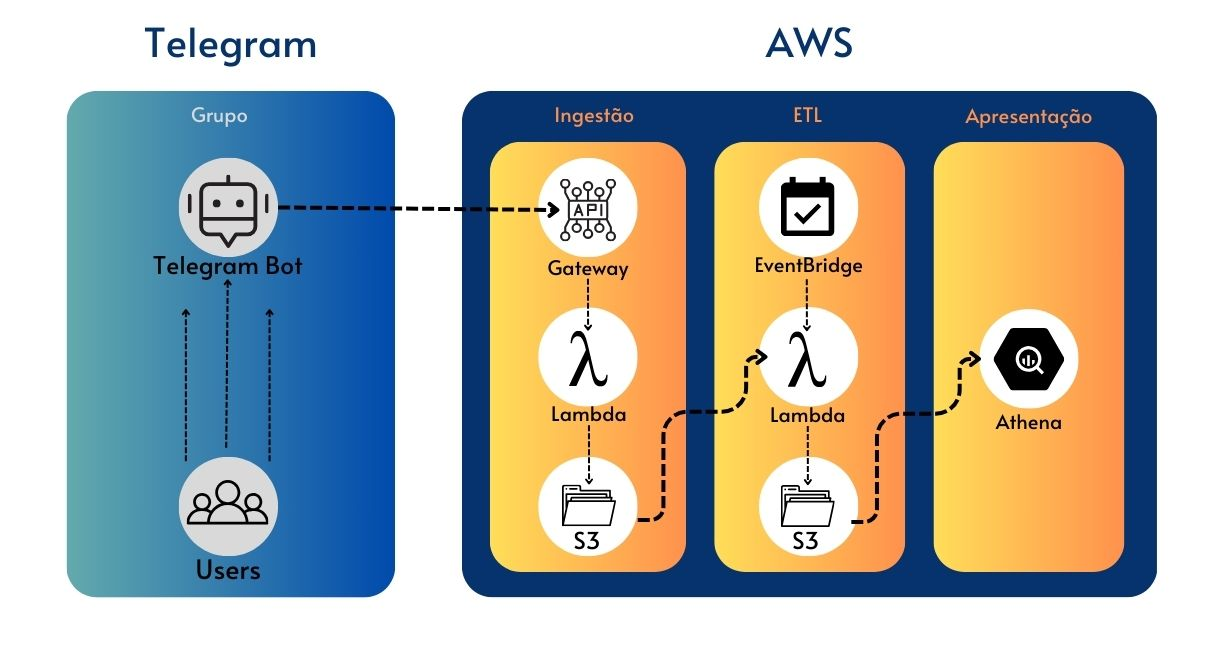

**1. Início do Processo:** O ponto de partida consiste em um grupo específico no Telegram, denominado "users". Este grupo é composto por pessoas comuns que participam de um canal no qual o bot criado está ativo.

**2. Leitura de Mensagens pelo Bot:** Cada mensagem enviada nesse grupo é lida pelo bot, responsável por processar e encaminhar as informações.

**3. Envio para a API Gateway na AWS:** As mensagens capturadas pelo bot são encaminhadas para uma API Gateway configurada na AWS, criando uma interface eficiente para a entrada de dados.

**4. Lambda AWS para Ingestão de Dados:** A API Gateway transfere as mensagens para uma função Lambda na AWS, especificamente desenvolvida para processar e direcionar as informações brutas para um bucket S3 na AWS.

**5. Processo de Ingestão de Dados:** Este estágio representa a ingestão inicial dos dados no ambiente AWS, estabelecendo a base para futuras etapas de processamento e análise.

**6. ETL - Extração, Transformação e Carregamento:** O próximo passo envolve o AWS EventBridge, que agendará a execução periódica de uma função Lambda dedicada à Extração, Transformação e Carregamento (ETL) dos dados brutos.

**7. Enriquecimento de Dados e Novo Bucket S3:** 
A função Lambda, durante a execução programada, processa os dados, enriquecendo-os conforme necessário, e, em seguida, armazena o resultado em um novo bucket S3 na AWS.

**8. AWS Athena para Consulta de Dados:** 
Finalmente, os dados enriquecidos estão prontos para serem acessados através do AWS Athena. Este serviço permite que os usuários consultem diariamente os dados armazenados, realizem análises organizadas e extraiam informações conforme necessário. Este processo estruturado e automatizado proporciona uma abordagem eficaz e organizada para a coleta, processamento e disponibilização de dados a partir do grupo no Telegram, capacitando os usuários a realizar consultas e análises de maneira eficiente.

## 3. Análise Exploratória de Dados
Neste momento, vamos analisar e explorar os dados. Estaremos investigando profundamente para encontrar insights valiosos nas informações disponíveis. Essa etapa crítica nos ajudará a entender padrões e tendências nos dados, fornecendo uma base sólida para decisões informadas. Ao realizar essa análise, vamos explorar diferentes aspectos dos dados, usando técnicas avançadas para descobrir nuances importantes.

### 3.1. Ingestão
A etapa de ingestão envolve a transferência de dados transacionais para ambientes analíticos. Os dados são persistidos no formato original, sem transformações no conteúdo ou na estrutura. A ingestão pode ser realizada em lote (batch) ou em tempo real (streaming).

No projeto, as mensagens capturadas pelo bot do Telegram são ingeridas via streaming, utilizando um webhook para redirecionar as mensagens para uma API web. Isso é feito através do AWS API Gateway, que encaminha os dados para o AWS Lambda. O Lambda armazena as mensagens no formato JSON em um bucket do AWS S3.

O AWS S3 atua como um repositório passivo para armazenar as mensagens no formato original. O sufixo "-raw" é adicionado ao nome do bucket. O AWS Lambda, por sua vez, opera ativamente, persistindo as mensagens no bucket do S3 de acordo com as condições estabelecidas. O processo assegura que apenas as mensagens provenientes do grupo correto do Telegram sejam armazenadas.

Esse fluxo de ingestão é parte de um sistema event-driven, onde eventos desencadeiam ações específicas. O processo inclui a criação do bucket no AWS S3, a configuração do AWS Lambda e do AWS API Gateway, bem como a configuração do webhook da API de bots do Telegram.

Abaixo o código da função usada no lambda S3:

In [1]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve, 
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')
  
  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Para garantir o correto funcionamento da função AWS Lambda, realizei as seguintes configurações:

1. **Variáveis de Ambiente:**
   - Configurei as variáveis AWS_S3_BUCKET (nome do bucket do AWS S3) e TELEGRAM_CHAT_ID (ID do chat do grupo do Telegram) na console da função AWS Lambda. Variáveis de ambiente são recomendadas para armazenar informações sensíveis.

2. **Permissão:**
   - Adicionei permissão de escrita no bucket do AWS S3 para a função AWS Lambda no AWS IAM.

3. **AWS API Gateway:**
   - Configurei o AWS API Gateway para receber mensagens do bot do Telegram via webhook e acionar a função AWS Lambda. As etapas incluíram:
      - Criação de uma API REST com sufixo "-api".
      - Estabelecimento de um método POST para integração com a função AWS Lambda.
      - Habilitação do uso de integração proxy Lambda.
      - Teste da integração usando a ferramenta de testes do serviço.
      - Implantação da API e obtenção do endereço web (URL) copiando a variável aws_api_gateway_url.

Essas configurações asseguram que a função AWS Lambda seja capaz de receber, processar e armazenar as mensagens corretamente, proporcionando uma integração eficaz entre o AWS API Gateway e o AWS Lambda.

Para integrar o bot do Telegram ao AWS API Gateway, configurei o webhook para redirecionar as mensagens para a URL do AWS API Gateway usando o método setWebhook. Destaco que os métodos getUpdates e setWebhook são mutuamente exclusivos, e enquanto o webhook estiver ativo, o método getUpdates não funcionará. A desativação do webhook é feita pelo método deleteWebhook. 

Abaixo os códigos para interar o AWS com o WebHook:

In [2]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

NameError: name 'requests' is not defined

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

### 3.2. ETL

Na etapa de ETL, mensagens diárias são inicialmente armazenadas na camada "crua" e, em seguida, processadas ativamente pelo AWS Lambda. Este, ao listar arquivos JSON na camada "crua" do AWS S3, faz o download, executa operações de data wrangling e persiste as mensagens processadas em formato Parquet na camada "enriquecida" do mesmo S3.

**ETL - Extração, Transformação e Carregamento (AWS Lambda):**
1. Mensagens do Telegram inicialmente armazenadas na camada "crua" do AWS S3.
2. Função AWS Lambda ativamente processa mensagens do dia anterior (D-1).
3. Operações de data wrangling aplicadas às mensagens.
4. Compactação em arquivo Parquet e persistência na camada "enriquecida" do AWS S3.
   
**AWS S3:**
- Camada "crua" armazena passivamente mensagens processadas.
- Adição do sufixo "-enriched" ao nome do bucket define a camada "enriquecida".

**Recorrência do Processo:**
- Função Lambda é acionada periodicamente pelo AWS Event Bridge.
- Listagem e processamento recorrente de arquivos JSON da camada "crua".

Abaixo os códigos das funcções:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False

In [ ]:
#O código da função de data wrangling:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para assegurar o funcionamento da função AWS algumas medidas foram tomadas antes:

1. **Variáveis de Ambiente:**
   - Configure as variáveis de ambiente AWS_S3_BUCKET (nome do bucket do AWS S3 da camada "crua") e AWS_S3_ENRICHED (nome do bucket do AWS S3 da camada "enriquecida") na console da função AWS Lambda.

2. **Permissão:**
   - Adicione permissão de escrita nos buckets do AWS S3 para a função AWS Lambda no AWS IAM.

3. **Recursos:**
   - Ajuste o timeout da função para 5 minutos, especialmente para lidar com operações de input/output (I/O) de arquivos do AWS S3.

4. **Camadas (Layers):**
   - Adicione o pacote Python PyArrow ao ambiente de execução da função usando camadas. Faça o upload do código do PyArrow para um bucket do AWS S3 e conecte-o à função como uma camada.

5. **AWS Event Bridge:**
   - Configure o AWS Event Bridge para ativar diariamente a função de ETL do AWS Lambda, agindo como um agendador.

   Nota: A função processa as mensagens do dia anterior (D-1).

### 3.3. Apresentação
Durante a apresentação, disponibilizarei um repositório no GitHub contendo detalhes das consultas e a implementação do código no AWS Athena. O link permitirá uma análise detalhada, facilitando a compreensão do processo de automação de dados. Os resultados das consultas serão apresentados de maneira organizada, oferecendo insights e destacando a eficácia da automação para uma compreensão aprofundada do valor gerado.

https://github.com/fabslo/Repositorio-Telegram-Project

- Mensagens implementada no grupo do telegram onde o bot estava implatado:
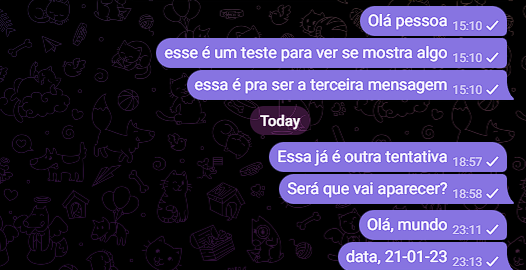

- 10 primeiras linhas para observar o resultado:
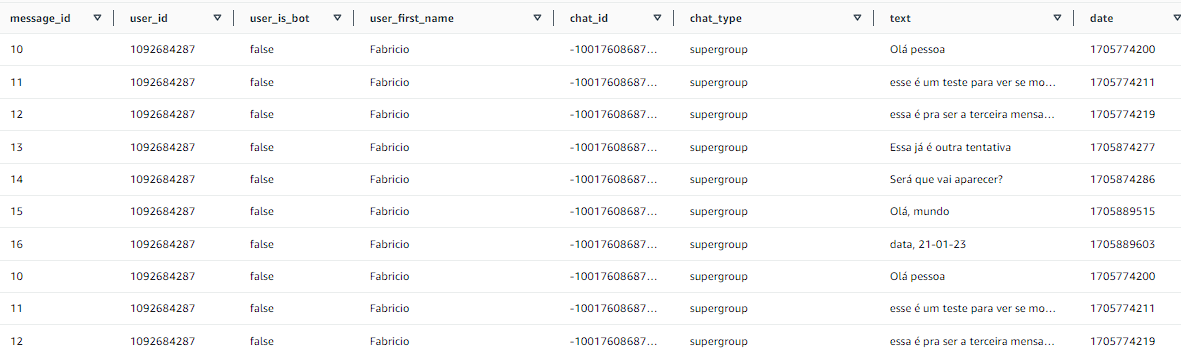

- Quantidade de mensagens por dia.

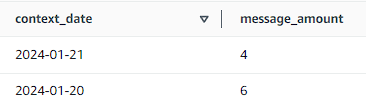

- Quantidade de mensagens por usuário por dia.

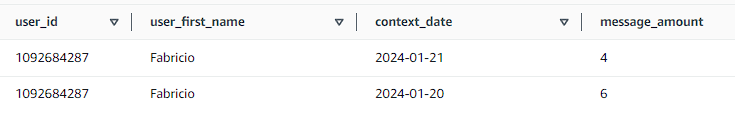

- Média do tamanho das mensagens por usuário por dia.

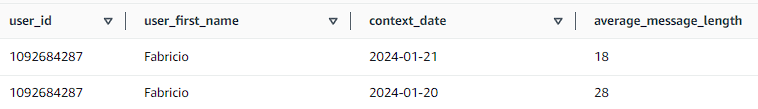

- Quantidade de mensagens por hora por dia da semana por número da semana.

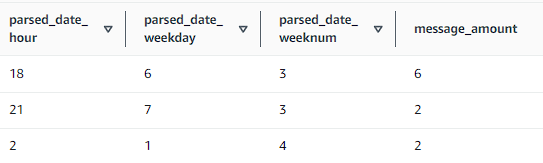

### 3.4. Melhorias Resumidas

O projeto, apesar de inicialmente simples, revela complexidade e potencial para expansão. Sugestões de melhorias incluem:

1. **Infraestrutura:**
   - Estender a atualização automática de novas partições da tabela no AWS Athena para o AWS Lambda, ampliando a gestão da infraestrutura.

2. **Dados:**
   - Aprimorar a abrangência do projeto, atualmente centrado em mensagens de texto, incorporando outros tipos de dados do grupo do Telegram. Adicionar campos às funções de ETL e tabelas do AWS Athena para dados variados.

3. **Consultas:**
   - Explorar e implementar consultas SQL adicionais na camada analítica do AWS Athena, maximizando a capacidade analítica e proporcionando insights mais detalhados.